# Regressão quantílica

É uma complmentação da regressão linear. <br>
Indicada quando existe outliers e heterocedasticidade (forte dispersão dos dados em torno de uma reta).<br>
Utiliza os quantis como referência, pois a média não descreve toda a distribuição, como no caso da regressão linear. <br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
gasto = pd.read_excel('dados/gasto_almoco.xlsx')

In [3]:
gasto

,dia,gasto_dia_reais,num_refeicoes,gasto_acum_reais
0,1,26,1,26
1,2,18,2,44
2,3,37,3,81
3,4,21,4,102
4,5,39,5,141
...,...,...,...,...
59,60,33,60,1826
60,61,38,61,1864
61,62,122,66,1986
62,63,34,67,2020


In [4]:
gasto.shape

(64, 4)

In [5]:
gasto.dtypes

dia                 int64
gasto_dia_reais     int64
num_refeicoes       int64
gasto_acum_reais    int64
dtype: object

In [6]:
gasto.isnull().sum()

dia                 0
gasto_dia_reais     0
num_refeicoes       0
gasto_acum_reais    0
dtype: int64

###### Análise de regressão linear

In [7]:
import matplotlib.pyplot as plt

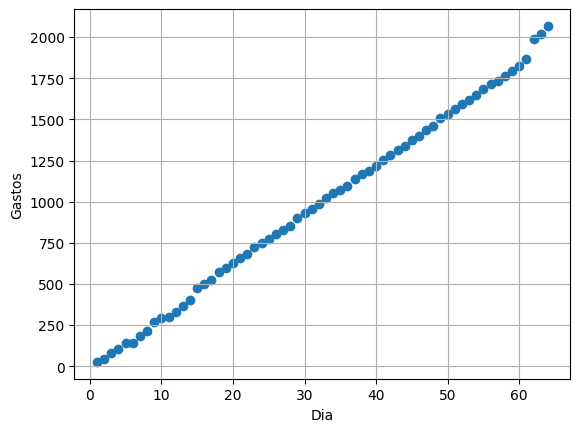

In [8]:
plt.scatter(gasto.dia, gasto.gasto_acum_reais)
plt.xlabel('Dia')
plt.ylabel('Gastos')
plt.grid(True)
plt.show()

###### Análise de normalidade

Gráfico QQ-Plot

In [9]:
import scipy.stats as stats

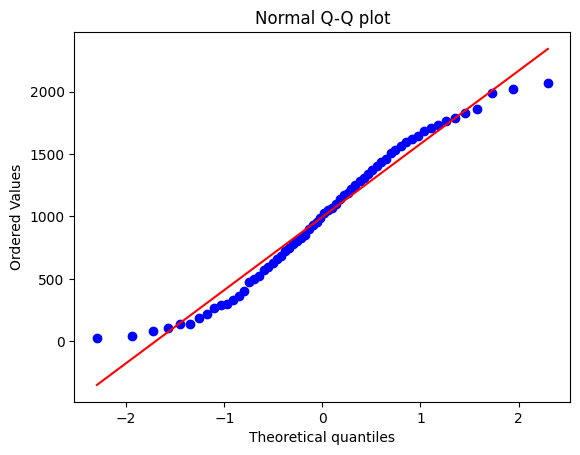

In [10]:
stats.probplot(gasto['gasto_acum_reais'], dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

<b>Teste Shapiro-Wilk </b><br>
Ho = distribuição normal: p > 0.05 <br>
Ha = distribuição != normal: p <= 0.05

In [11]:
stats.shapiro(gasto.gasto_acum_reais)

ShapiroResult(statistic=0.9621436595916748, pvalue=0.047125596553087234)

In [12]:
estatistica, p_valor = stats.shapiro(gasto.gasto_acum_reais)
print(f'Estatística do teste: {estatistica}')
print(f'             P-valor: {p_valor}')
# A distribuição não é normal, por isso o uso de spearman

Estatística do teste: 0.9621436595916748
             P-valor: 0.047125596553087234


##### Correlação linear
Pearson (distribuição normal) <br>
Spearman (distribuição não normal) <br>
Kendall (distribuição não normal com quantidade pequena de amostras)

H0 = não há correlação linear: p > 0.05<br>
Ha = existe correlação linear: p <= 0.05

In [13]:
# Pearson
coef, p_valor = stats.pearsonr(gasto.dia, gasto.gasto_acum_reais)
print(f'Coeficiente de correlação: {coef}') # Quase perfeita
print(f'               P-valor: {p_valor}') # Existe correlação linear

Coeficiente de correlação: 0.9991907427078194
               P-valor: 3.030401482831247e-88


In [14]:
# Spearman - utilizadoquando a distribuiçãonão é normal
coef, p_valor = stats.spearmanr(gasto.dia, gasto.gasto_acum_reais)
print(f'Coeficiente de correlação: {coef}') # Quase perfeita
print(f'             P-valor: {p_valor}') # Existe correlação linear
# p-valor bem menor que 0.05

Coeficiente de correlação: 0.9999885530480366
             P-valor: 1.4296719644744235e-145


## Modelo de regressão linear

In [15]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [16]:
# Criação do modelo
regressao_linear = smf.ols('gasto_acum_reais ~ dia', data=gasto).fit()

In [17]:
residuos = regressao_linear.resid

#### Teste de Normalidade dos resíduos

H0 = distribuição normal: p > 0.05<br>
Ha = distribuição != normal: p <= 0.05

In [18]:
estatistica, p_valor = stats.shapiro(residuos)
print(f'Estatística do teste: {estatistica}')
print(f'           P-valor: {p_valor}')
# P-valor bem menor que 0.05, distribuição não normal

Estatística do teste: 0.8646502494812012
           P-valor: 4.71544126412482e-06


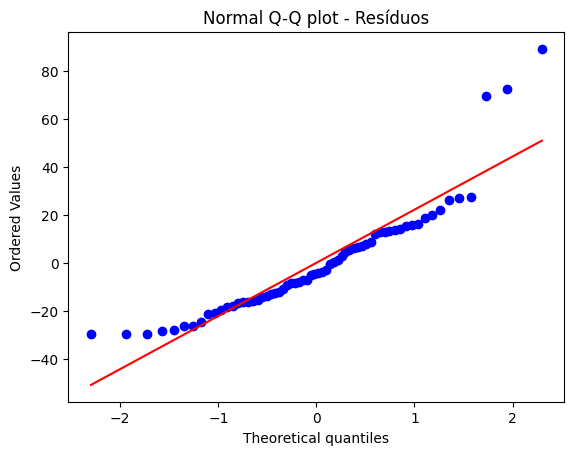

In [19]:
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Resíduos")
plt.show()

### Análise da homocedasticidade dos resíduos
(resíduos com variação constante)

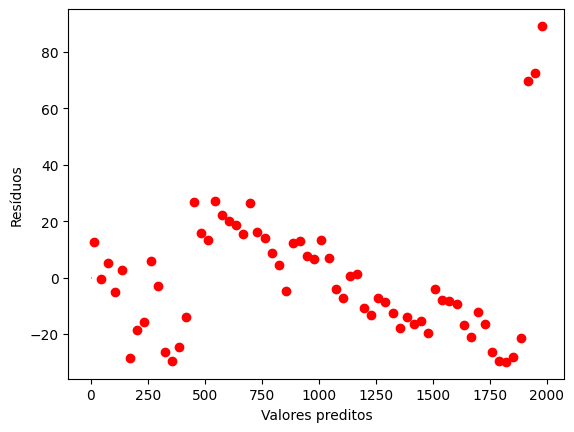

In [20]:
plt.scatter(y=residuos, x=regressao_linear.predict(), color='red')
plt.hlines(y=0,xmin=0,xmax=4, color="orange")
plt.ylabel("Resíduos")
plt.xlabel("Valores preditos")
plt.show()

Teste Breusch-Pagan (Homocedasticidade ou Heterocedasticidade)

H0 = existe homocedasticidade: p > 0.05 <br>
Ha = não existe homocedasticidade: p <= 0.05

In [21]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [23]:
estatistica, p_valor, f, fp = sms.het_breuschpagan(regressao_linear.resid, regressao_linear.model.exog)
print(f"Estatística de teste: {estatistica}")
print(f"P-valor: {p_valor}")
print(f"f-valor: {f}")
print(f"f_p-valor {fp}")
# Não existe homocedasticidade, não sendo possível trabalhar com regressão linear, agora usaremos a regreesão quantílica

Estatística de teste: 8.551798019780456
P-valor: 0.0034518111668789633
f-valor: 9.562284407626684
f_p-valor 0.0029756698764907595


##### Outliers nos resíduos
Entre -3 e 3

In [24]:
outliers = regressao_linear.outlier_test()

In [26]:
outliers.max()

student_resid    4.458242
unadj_p          0.982688
bonf(p)          1.000000
dtype: float64

In [27]:
outliers.min()

student_resid   -1.305146
unadj_p          0.000036
bonf(p)          0.002309
dtype: float64

<b>Modelo reprovado: Resíduos sem distribuição normal, com presença de outliers e heterocedasticidade </b><br>
P-valor: 0.0034518111668789633 | student_resid    4.458242

## Modelo de regressão quantílica

In [29]:
modelo1 = smf.quantreg('gasto_acum_reais ~ dia', gasto) # var dep e depois a indep
resultado = modelo1.fit(q=0.25)
print(resultado.summary())

                         QuantReg Regression Results                          
Dep. Variable:       gasto_acum_reais   Pseudo R-squared:               0.9705
Model:                       QuantReg   Bandwidth:                       19.83
Method:                 Least Squares   Sparsity:                        52.15
Date:                Sat, 11 Mar 2023   No. Observations:                   64
Time:                        09:18:37   Df Residuals:                       62
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7143      6.536     -3.322      0.002     -34.780      -8.648
dia           30.9286      0.181    171.127      0.000      30.567      31.290


<b>Equação:</b> gasto_acum = -21.7143 + 30.9286 * dia

In [30]:
modelo2 = smf.quantreg('gasto_acum_reais ~ dia', gasto)
resultado = modelo1.fit(q=0.5)
print(resultado.summary())

                         QuantReg Regression Results                          
Dep. Variable:       gasto_acum_reais   Pseudo R-squared:               0.9691
Model:                       QuantReg   Bandwidth:                       19.52
Method:                 Least Squares   Sparsity:                        43.96
Date:                Sat, 11 Mar 2023   No. Observations:                   64
Time:                        09:20:09   Df Residuals:                       62
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.0313      5.560     -1.445      0.154     -19.145       3.082
dia           30.7813      0.149    206.976      0.000      30.484      31.079


<b>Equação:</b> gasto_acum = -8.0313 + 30.7813 * dia

In [32]:
modelo3 = smf.quantreg('gasto_acum_reais ~ dia', gasto)
resultado = modelo3.fit(q=0.75)
print(resultado.summary())

                         QuantReg Regression Results                          
Dep. Variable:       gasto_acum_reais   Pseudo R-squared:               0.9624
Model:                       QuantReg   Bandwidth:                       15.65
Method:                 Least Squares   Sparsity:                        45.18
Date:                Sat, 11 Mar 2023   No. Observations:                   64
Time:                        09:37:05   Df Residuals:                       62
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4074      4.735      2.831      0.006       3.942      22.873
dia           30.4815      0.124    246.731      0.000      30.235      30.728


<b>Equação:</b> gasto_acum = 13.4074 + 30.4815 * dia

In [34]:
modelo4 = smf.quantreg('gasto_acum_reais ~ dia', gasto)
resultado = modelo4.fit(q=0.85)
print(resultado.summary())

                         QuantReg Regression Results                          
Dep. Variable:       gasto_acum_reais   Pseudo R-squared:               0.9537
Model:                       QuantReg   Bandwidth:                       27.08
Method:                 Least Squares   Sparsity:                        94.22
Date:                Sat, 11 Mar 2023   No. Observations:                   64
Time:                        09:38:13   Df Residuals:                       62
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4000     10.507     -0.514      0.609     -26.403      15.603
dia           31.4000      0.276    113.865      0.000      30.849      31.951


<b>Equação:</b> gasto_acum = -5.4 + 31.4 * dia

In [35]:
modelo5 = smf.quantreg('gasto_acum_reais ~ dia', gasto)
resultado = modelo5.fit(q=0.99999)
print(resultado.summary())

                         QuantReg Regression Results                          
Dep. Variable:       gasto_acum_reais   Pseudo R-squared:               0.9545
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Sat, 11 Mar 2023   No. Observations:                   64
Time:                        09:41:22   Df Residuals:                       62
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4127        nan        nan        nan         nan         nan
dia           32.4127        nan        nan        nan         nan         nan


<b>Equação:</b> gasto_acum = -6.4127 + 32.4127 * dia

<b>Comparando com a regressão linear.

In [36]:
print(regressao_linear.summary())

                            OLS Regression Results                            
Dep. Variable:       gasto_acum_reais   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.826e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.03e-88
Time:                        09:46:44   Log-Likelihood:                -292.04
No. Observations:                  64   AIC:                             588.1
Df Residuals:                      62   BIC:                             592.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.8542      5.963     -2.994      0.0

<b>Equação:</b> gasto_acum = -17.8542 + 31.1984 * dia